In [1]:
import telebot;
from telebot import types
from telebot.types import Chat
import telegram
import sys

import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# fix random seed for reproducibility
numpy.random.seed(7)

import sqlite3 as sq
from sqlite3 import Error
import pandas as pd

from datetime import datetime
import pytz
from statsmodels.tsa.api import ExponentialSmoothing

In [2]:
#Последний год даных
data_last_year=(datetime.now(pytz.timezone('UTC'))).year-1

In [3]:
def load_data(): 
    dataframe = pandas.read_csv('../data/population.csv',  engine='python', skipfooter=3)
    return dataframe

def create_list_of_countries(choise, dataframe):
   za=dataframe[['Country_Name','Country_Code']]
   za=za.groupby('Country_Name').min()
   za['Country_Code'] = za.index.map(lambda x: x[0].lower())
   za=(za[za["Country_Code"]==choise]).index.to_list()
   return za

def create_list_of_years_for_choose(dataframe):
    dataset = dataframe.values
    Years= [i[2] for i in dataset]
    Years = list(set(Years))
    Years.sort()
    while Years[-1]<2100:
        Years.append(Years[-1]+1)
    Years = list(map(str, Years))
    return Years

#Выбор из базы данных данных по выбранной стране
#columns_names - имена полей по которым нужно вывести данные из базы
#Choosed_country - выбранная страна
#Conditions - доп. условие 
def data_sampling_universal(columns_names, Choosed_country, Conditions):
    Choosed_country='"'+Choosed_country+'"'
    sql_text='SELECT '+columns_names+' FROM countries_population where Country_Name='
    sql_text=sql_text+Choosed_country
    if Conditions!=None:
        sql_text=sql_text+' and ' + Conditions
    
    cols=(columns_names.split(', '))
    q_col=len(cols)
    result=numpy.array([]) 
    with sq.connect("countries.db") as con:
        cur=con.cursor()
        cur.execute(sql_text)
        fields=cur.fetchall()

    result={}
    for j in range(q_col):
        for i in range(int(len(fields))):
            old_data=result.get(cols[j])
            #Если не первый раз проходим - тогда сохряем предыдущие значения этой метки словаря
            #а потом добавляе новые значение сверху - так добиваемся универсальности запроса
            # в части произвольности колонок
            if old_data!=None:
                #break
                old_data.append(int(fields[i][j])) 
                new_elem= {cols[j]:old_data}
                result.update(new_elem)
            #Если первый раз проходим - тогда вставляем значения для этой метки словаря
            else:
                new_elem= {cols[j]:[int(fields[i][j])]}
                result.update(new_elem)
    return result            

#Определим последний год по данным данной старны
def last_data_of_choosed_country(Choosed_country):
    Choosed_country='"'+Choosed_country+'"'
    sql_text='SELECT DISTINCT max(Year) from countries_population where Country_Name='
    sql_text=sql_text+Choosed_country
    with sq.connect("countries.db") as con:
        cur=con.cursor()
        cur.execute(sql_text)
        fields=cur.fetchall()
    result= fields[0][0]
    return result

#Определим первый год по данным данной старны
def first_data_of_choosed_country(Choosed_country):
    Choosed_country='"'+Choosed_country+'"'
    sql_text='SELECT DISTINCT min(Year) from countries_population where Country_Name='
    sql_text=sql_text+Choosed_country
    with sq.connect("countries.db") as con:
        cur=con.cursor()
        cur.execute(sql_text)
        fields=cur.fetchall()
    result= fields[0][0]
    return result

#Загрузка данных из *.csv в SQL базу 
def load_data_frame_to_sql(dataframe, sql_db_name):
    with sq.connect(sql_db_name) as con:
        cur = con.cursor() #get the count of tables with the name
        cur.execute(''' SELECT count(name) FROM sqlite_master WHERE type='table' AND name='countries_population' ''') 
        #if the count is 1, then table exists 
        if cur.fetchone()[0]==1 : 
            { print('Table alredy exists.') }
        else:
            Frame_types= {"Country_name": "text", "Year": "integer", "Value": "integer"}
            dataframe.to_sql('countries_population', con=sq.connect(sql_db_name), schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=Frame_types, method=None)
    
#Функция разделения на Y и Х временные ряды из dataset с шагом отставания в look_back
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

#Функция создание списка лет
def create_list_of_years(Choosed_year, Choosed_country):
    first_year=first_data_of_choosed_country(Choosed_country)
    last_year_in_base=last_data_of_choosed_country(Choosed_country)
    forecast_lenth=int(Choosed_year)-last_year_in_base  
    mylist=[]
    for i in range(int(Choosed_year)-first_year+1):
        mylist.append(first_year+i)
    return mylist

#Функция прогноза
#Quantity_yeas - на сколько лет делаем погноз
#list_of_values - лист значений, временной ряд по которому делаем прогноз
def forecast(list_of_values, Quantity_yeas):
    dataset = numpy.asarray (list_of_values)
    dataset=numpy.reshape(dataset, (dataset.shape[0], 1))
    dataset = dataset.astype('float32')
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    dataset = scaler.fit_transform(dataset)

    train = dataset.copy()
    #train = scaler.fit_transform(dataset)
    # split into train and test sets
    #train_size = int(len(dataset) * 0.95)
    #test_size = len(dataset) - train_size
    #train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
    #print(len(train), len(test))
    # Его можно настроить, и мы построим набор данных другой формы в следующем разделе.
    # convert an array of values into a dataset matrix
    # reshape into X=t and Y=t+1
    look_back = 1
    trainX, trainY = create_dataset(train, look_back)
    #testX, testY = create_dataset(test, look_back)
    # reshape input to be [samples, time steps, features]
    trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    #testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    # create and fit the LSTM network
    model = Sequential()
    #model.add(Embedding(input_dim=len(dataset), output_dim=4))
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
    #+Inicialization
    #Quantity_yeas =50
    New_Forecast = []
    #New_Forecast = trainY.copy()
    New_Forecast = numpy.reshape(dataset, (dataset.shape[0]))
    #-Inicialization
    #+New_times_row
    for i in range(Quantity_yeas):
        New_Forecast = numpy.reshape(New_Forecast, (New_Forecast.shape[0], 1, 1))
        NewPredict = model.predict(New_Forecast)
        model.fit(New_Forecast, NewPredict, epochs=10, batch_size=1, verbose=2)
        #New_Forecast = numpy.append(New_Forecast[1:], NewPredict[len(NewPredict)-1:])
        New_Forecast = numpy.append(New_Forecast[:], NewPredict[len(NewPredict)-1:])
        
    New_Forecast = numpy.reshape(New_Forecast, (New_Forecast.shape[0], 1))
    trainPredict = New_Forecast.copy()
    #-New_times_row
    #ОБРАТНАЯ трансформация из нормализации в обычный вид 
    trainPredict = scaler.inverse_transform(trainPredict)
    #ОБРАТНЫЙ перевод в лист
    trainPredict=numpy.reshape(trainPredict, (trainPredict.shape[0], ))
    trainPredict = trainPredict.astype('int')
    trainPredict=trainPredict.tolist()
    return trainPredict

# График
def graf(trainPredict):
#inv_dataset=scaler.inverse_transform(dataset)
#plt.plot(inv_dataset, color='yellow')
    plt.plot(trainPredict, color='green', linestyle='dashed')
    plt.show()

#Вставка данных в таблицу
def insert_varible_into_table(Base_name,Table_name, Country_name, Country_code, Year, Value):
    #with sq.connect("countries.db") as con:
    #    cur = con.cursor() #get the count of tables with the name
    #    cur.execute(''' SELECT count(name) FROM sqlite_master WHERE type='table' AND name='countries_population' ''') 
      
    #countries_population  
    try:
        sqlite_connection = sq.connect(Base_name)
        cursor = sqlite_connection.cursor()
        #print("Подключен к SQLite")
        sqlite_insert_with_param = """INSERT INTO {table}
                              (Country_name, Country_code, Year, Value)
                              VALUES (?, ?, ?, ?);"""
        
        #cur.execute("INSERT INTO db.{table} SELECT distinct latitude, longitude, port FROM MessageType1 ".format(minlat = bottomlat, maxlat = toplat, minlong = bottomlong, maxlong = toplong, table=tablename))
        
        data_tuple = (Country_name, Country_code, Year, Value)
        cursor.execute((sqlite_insert_with_param.format(table=Table_name)), data_tuple)
        sqlite_connection.commit()
        #print("Переменные Python успешно вставлены в таблицу countries_population'")

        cursor.close()

    except sq.Error as error:
        print("Ошибка при работе с SQLite", error)
    finally:
        if sqlite_connection:
            sqlite_connection.close()
            #print("Соединение с SQLite закрыто")

#График
def graf_save(list_of_years, list_of_values, name_of_file):
    # Построение графика
    plt.title("Population changes") # заголовок
    plt.xlabel("Years") # ось абсцисс
    plt.ylabel("Population") # ось ординат
    plt.grid()      # включение отображение сетки
    plt.plot(list_of_years, list_of_values, 'g')  # построение графика
    plt.savefig(name_of_file)

def graf_save2(list_of_years, list_of_historical_values, list_of_forecast_values1, list_of_forecast_values2, label1, label2, name_of_file):
    # Построение графика
    plt.title("Population changes") # заголовок
    plt.xlabel("Years") # ось абсцисс
    plt.ylabel("Population") # ось ординат
    plt.grid()      # включение отображение сетки
    list_of_years_historical_data=list_of_years[:(-1)*len(list_of_forecast_values1)]
    list_of_values1=list_of_historical_values+list_of_forecast_values1
    list_of_values2=list_of_historical_values+list_of_forecast_values2
    plt.plot(list_of_years, list_of_values1, color='g', label=label1)  # построение графика
    plt.plot(list_of_years, list_of_values2, color='b', label=label2)  # построение графика
    plt.plot(list_of_years_historical_data,list_of_historical_values, color='y', label='HISTORICAL DATA')
    plt.legend()
    plt.savefig(name_of_file)

def ExponentialSmoothing_forecast(serial,forecast_len):
    fit1=ExponentialSmoothing(numpy.asarray(serial),seasonal_periods=7,trend='add', seasonal='add',).fit()
    return list(fit1.forecast(forecast_len))


In [4]:
#Загрузка данных из *.csv в SQL базу 
dataframe=load_data()
dataframe= dataframe.rename(columns={'Country Name': 'Country_Name', 'Country Code': 'Country_Code'})
load_data_frame_to_sql(dataframe, "countries.db")

Table alredy exists.


In [5]:
Choosed_country='Aruba'
Choosed_year='2036'
Conditions = 'Year<='+str(Choosed_year)
last_year_in_base=last_data_of_choosed_country(Choosed_country)
forecast_lenth=int(Choosed_year)-last_year_in_base
list_of_years=create_list_of_years(Choosed_year, Choosed_country)
sql_sampled_data=data_sampling_universal("Value", Choosed_country,None)
list_of_historical_values=sql_sampled_data.get("Value")
list_of_values_forecast = forecast(list_of_historical_values, forecast_lenth)
list_of_values_forecast2=list_of_values_forecast[(-1)*forecast_lenth:]

Epoch 1/100
62/62 - 6s - loss: 0.3150 - 6s/epoch - 96ms/step
Epoch 2/100
62/62 - 0s - loss: 0.2452 - 310ms/epoch - 5ms/step
Epoch 3/100
62/62 - 0s - loss: 0.1961 - 273ms/epoch - 4ms/step
Epoch 4/100
62/62 - 0s - loss: 0.1627 - 267ms/epoch - 4ms/step
Epoch 5/100
62/62 - 0s - loss: 0.1379 - 271ms/epoch - 4ms/step
Epoch 6/100
62/62 - 0s - loss: 0.1200 - 270ms/epoch - 4ms/step
Epoch 7/100
62/62 - 0s - loss: 0.1072 - 274ms/epoch - 4ms/step
Epoch 8/100
62/62 - 0s - loss: 0.0976 - 280ms/epoch - 5ms/step
Epoch 9/100
62/62 - 0s - loss: 0.0896 - 271ms/epoch - 4ms/step
Epoch 10/100
62/62 - 0s - loss: 0.0834 - 266ms/epoch - 4ms/step
Epoch 11/100
62/62 - 0s - loss: 0.0774 - 270ms/epoch - 4ms/step
Epoch 12/100
62/62 - 0s - loss: 0.0717 - 275ms/epoch - 4ms/step
Epoch 13/100
62/62 - 0s - loss: 0.0664 - 265ms/epoch - 4ms/step
Epoch 14/100
62/62 - 0s - loss: 0.0611 - 280ms/epoch - 5ms/step
Epoch 15/100
62/62 - 0s - loss: 0.0554 - 280ms/epoch - 5ms/step
Epoch 16/100
62/62 - 0s - loss: 0.0501 - 270ms/epoc

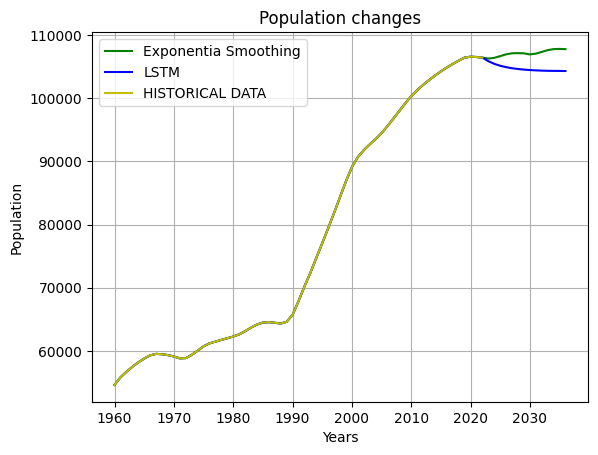

In [6]:
graf_save2(list_of_years, list_of_historical_values,ExponentialSmoothing_forecast(list_of_historical_values, forecast_lenth),list_of_values_forecast2, 'Exponentia Smoothing','LSTM','plot_name.png')

In [ ]:
Token="6387791190:AAFDsWVbZkCiFyTmVMALbLOZB4zZLSLnSRA"
bot = telebot.TeleBot(Token)
alphabet = [chr(i) for i in range(97, 123)]
Countries_list=[]
Years_list=[]
Choosed_country=''
Choosed_year=''
Update_base=False
Update_contry=False
Update_All=False
text_out=""

Years_list=create_list_of_years_for_choose(dataframe)

In [ ]:
@bot.message_handler(commands=['start'])
def start(message):
    markup = types.ReplyKeyboardMarkup(resize_keyboard=True)
    item1=types.KeyboardButton('Обновить')
    item2=types.KeyboardButton('Обновить все')
    item3=types.KeyboardButton('Первая буква в названии страны')

    markup.add(item1, item2, item3)
    bot.send_message(message.chat.id, text='Hi', reply_markup=markup)

@bot.message_handler(commands=['stop']) 
def stop(message): 
    markup = types.ReplyKeyboardMarkup(resize_keyboard=True)
    bot.send_message(message.chat.id, text='Stop')
    #telegram.ext.Updater.stop()
    bot.stop_bot()
    #sys.exit(0)    

In [ ]:
@bot.message_handler(content_types=['text']) 
def bot_message(message): 
    global Countries_list
    global Choosed_country
    global Years_list
    global Choosed_year
    global data_last_year
    global text_out
    if message.text=='Обновить данные по стране':
        last_year_in_base=last_data_of_choosed_country(Choosed_country)
        if last_year_in_base<data_last_year:
            mess="Требуется обновление данных по стране"
            #Update_contry=True
        bot.send_message(message.chat.id,'Ok')
    elif message.text=='Обновить все':
        Update_All=True
        bot.send_message(message.chat.id,'Ok, all')
    elif message.text=='Первая буква в названии страны':
    # or 'Обновить данные по стране':
        markup = types.ReplyKeyboardMarkup(resize_keyboard=True)
        mass=[]
        for i in alphabet:
            item=types.KeyboardButton(i)
            mass.append(item)
        markup.add(*mass)    
        back=types.KeyboardButton('Назад')
        markup.add(back)
        bot.send_message(message.chat.id, text='Выбрана буква', reply_markup=markup)
    elif message.text in alphabet:    
        markup = types.ReplyKeyboardMarkup(resize_keyboard=True)
        Countries_list = create_list_of_countries(message.text, dataframe)
        mass=[]
        for i in Countries_list:
            item=types.KeyboardButton(i)
            mass.append(item)
        markup.add(*mass)
        back=types.KeyboardButton('Назад')
        markup.add(back)
        bot.send_message(message.chat.id, text='Выберете страну из списка', reply_markup=markup)
    elif message.text in Countries_list:    
        Choosed_country=message.text
        markup = types.ReplyKeyboardMarkup(resize_keyboard=True)
        mass=[]
        for i in Years_list:
            item=types.KeyboardButton(i)
            mass.append(item)
        markup.add(*mass)
        back=types.KeyboardButton('Назад')
        markup.add(back)
        bot.send_message(message.chat.id, text='Выберете год до которого хотите получить данные', reply_markup=markup)
    elif message.text in Years_list:    
        Choosed_year=message.text
        markup = types.ReplyKeyboardMarkup(resize_keyboard=True)
        last_year_in_base=last_data_of_choosed_country(Choosed_country)
        Conditions = 'Year<='+str(Choosed_year)
        text_out=''

        if int(Choosed_year)<=last_year_in_base:
            sql_sampled_data=data_sampling_universal("Year, Value", Choosed_country, Conditions)
            list_of_years=sql_sampled_data.get("Year")
            list_of_historical_values=sql_sampled_data.get("Value")
            for i in range(len(list_of_years)):
                text_out += f'{str(list_of_years[i])} - {str(list_of_historical_values[i])}\n'
            graf_save(list_of_years, list_of_historical_values,'plot_name.png')
        else:
            forecast_lenth=int(Choosed_year)-last_year_in_base
            list_of_years=create_list_of_years(Choosed_year, Choosed_country)
            sql_sampled_data=data_sampling_universal("Value", Choosed_country,None)
            list_of_historical_values=sql_sampled_data.get("Value")
            list_of_full_values_forecast = forecast(list_of_historical_values, forecast_lenth)
            list_of_only_values_forecast=list_of_full_values_forecast[(-1)*forecast_lenth:]
            ExponentialSmoothing_values = ExponentialSmoothing_forecast(list_of_historical_values, forecast_lenth)
            for i in range(len(list_of_years[:(-1)*forecast_lenth])):
                text_out += f'{str(list_of_years[i])} - {str(list_of_historical_values[i])}\n'
                #text_out += f'{str(list_of_years[i])} - {str(list_of_full_values_forecast[i])}\n'
                #Запись в базу, чтобы в следующий раз работало быстрее (прогноз не пересчитывался)
                #!!!
            for i in range(len(list_of_only_values_forecast)):
                now_num=len(list_of_years)-forecast_lenth+i
                text_out += f'{str(list_of_years[now_num])} - {str(list_of_only_values_forecast[i])}\n'
                insert_varible_into_table("countries.db","countries_population",Choosed_country, "", list_of_years[now_num], list_of_only_values_forecast[i])
                #if int(list_of_full_values_forecast[i])>last_year_in_base:
                   #insert_varible_into_table("countries.db","countries_population",Choosed_country, "", list_of_years[i], list_of_full_values_forecast[i]) 
            graf_save2(list_of_years, list_of_historical_values,ExponentialSmoothing_values, list_of_only_values_forecast, 'Exponentia Smoothing','LSTM','plot_name.png')
            #graf_save2(list_of_years, list_of_historical_values,ExponentialSmoothing_forecast(list_of_historical_values, forecast_lenth),list_of_values_forecast2, 'Exponentia Smoothing','LSTM','plot_name.png')
        back=types.KeyboardButton('Назад')
        markup.add(back)
        bot.send_message(message.chat.id, text=text_out, reply_markup=markup)    
        
        #graf_save2(list_of_years, list_of_values,ExponentialSmoothing_forecast(list_of_historical_data, forecast_lenth),list_of_values_forecast2, 'Exponentia Smoothing','LSTM','plot_name.png')
        
        bot.send_photo(message.chat.id, photo=open('plot_name.png', 'rb'))

    elif message.text=='Назад':
        text_out=""
        markup = types.ReplyKeyboardMarkup(resize_keyboard=True)
        item1=types.KeyboardButton('Обновить данные по стране')
        item2=types.KeyboardButton('Обновить все')
        item3=types.KeyboardButton('Первая буква в названии страны')

        markup.add(item1, item2, item3)
        bot.send_message(message.chat.id, text='Назад', reply_markup=markup)
        

In [ ]:
bot.polling(non_stop=True, interval=0)